In [1]:
import os
import gc
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.metrics import adjusted_rand_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from pyInfinityFlow.InfinityFlow_Utilities import move_features_to_silent
from pyInfinityFlow.InfinityFlow_Utilities import anndata_to_df
from pyInfinityFlow.InfinityFlow_Utilities import read_fcs_into_anndata
from pyInfinityFlow.InfinityFlow_Utilities import apply_logicle_to_anndata
from pyInfinityFlow.fcs_io import FCSFileObject

os.chdir("/Volumes/salomonis2/LabFiles/Kyle/Analysis/2022_12_07_new_multilin_panel/")

In [2]:
# Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))


def marker_finder(input_df, groups):
    """
    Function to find pearson correlation coefficient values and p-values for 
    the given data and groups for groups to test. The function will perform a 
    Pearson correlation of the input_df feature values to an "idealized" 
    group specific expression vector, where each observation in a given group
    is set to a value of 1, and the observations in other groups are set to 0.
    Arguments
    ---------
    input_df : pandas.DataFrame
        DataFrame with observations as index and features as columns (Required)
    
    groups : list[str]
        List-like of specified groups corresponding to observations from the 
        input_df. The order of groups should match the order in input_df.index
        (Required)
    Returns
    -------
    r_df
        a pandas.DataFrame containing the pearson
        correlation coefficient values for each marker to the idealized vector
        for each cluster.
    """
    ideal_vectors = pd.get_dummies(groups)
    ideal_vectors.index = input_df.index.values
    degrees_f = input_df.shape[0] - 2
    r_df = pearson_corr_df_to_df(input_df, ideal_vectors)
    # t_df = r_df*np.sqrt(degrees_f) / np.sqrt(1-(r_df**2))
    # p_df = t_df.applymap(lambda x: t.sf(abs(x), df=degrees_f)*2)
    return(r_df)

def map_min_max(input_array, input_min, input_max):
    tmp_scaler = 1 / (input_max - input_min)
    input_array = np.array(input_array)
    input_array[input_array < input_min] = input_min
    input_array[input_array > input_max] = input_max
    return(tmp_scaler * (np.array(input_array) - input_min))

In [ ]:
reference_adata, query_adata, obs_field, var_series,


reference_npcs=30, query_npcs=30,
reference_louvain_resolution=1, query_louvain_resolution=1,
use_zscore=True

In [3]:
### cellHarmony function 
def cellharmony(reference_adata, query_adata, obs_field, var_series,
        reference_npcs=30, query_npcs=30,
        reference_louvain_resolution=1, query_louvain_resolution=1,
        use_zscore=True):
    # Set up temporary variables for function
    ref_adata = reference_adata[:,var_series.index.values].copy()
    que_adata = query_adata[:,var_series.values].copy()
    ### Step 1: Define Communities
    print("\nStep 1: Defining Communities")
    ## Louvain Clustering
    # PCA
    print("\tRunning pca...")
    sc.tl.pca(ref_adata)
    sc.tl.pca(que_adata)

    plt.close("all")
    plt.plot(\
        list(range(1, 1+len(ref_adata.uns['pca']['variance_ratio']))),
        ref_adata.uns['pca']['variance_ratio'])
    plt.title("Reference PCA")
    plt.show()

    plt.close("all")
    plt.plot(\
        list(range(1, 1+len(que_adata.uns['pca']['variance_ratio']))),
        que_adata.uns['pca']['variance_ratio'])
    plt.title("Query PCA")
    plt.show()

    # Find Neighbors
    print("\tFinding neighbors...")
    sc.pp.neighbors(ref_adata, n_pcs=reference_npcs)
    sc.pp.neighbors(que_adata, n_pcs=query_npcs)

    # Louvain Clustering
    print("\tFinding Louvain communities...")
    sc.tl.louvain(ref_adata, resolution=reference_louvain_resolution)
    sc.tl.louvain(que_adata, resolution=query_louvain_resolution)

    ### Step 2: Find Closest Matching Communities
    print("\nStep 2: Find closest matching communities")
    # Normalize data by zscore if specified
    if use_zscore:
        ref_adata.X = zscore(ref_adata.X, axis=0)
        que_adata.X = zscore(que_adata.X, axis=0)

    # Generate Community Reference Centroids
    # Should total expression space be used, or is it better to use PCA space?
    ref_com_centroids = pd.DataFrame(\
        # ref_adata.obsm['X_pca'][:,:30], # PCA space
        ref_adata.X,
        index = ref_adata.obs.index.values,
        columns = ref_adata.var.index.values)
    ref_com_centroids["louvain"] = ref_adata.obs["louvain"].values
    ref_com_centroids = pd.pivot_table(\
        ref_com_centroids, 
        index="louvain", 
        aggfunc=np.mean)
    que_com_centroids = pd.DataFrame(\
        # que_adata.obsm['X_pca'][:,:30], # PCA space
        que_adata.X,
        index = que_adata.obs.index.values,
        columns = que_adata.var.index.values)
    que_com_centroids["louvain"] = que_adata.obs["louvain"].values
    que_com_centroids = pd.pivot_table(\
        que_com_centroids, 
        index="louvain", 
        aggfunc=np.mean)

    # Correlate community reference centroids
    # (query comes first, so it will be in rows of correlation matrix)
    com_correlations = pearson_corr_df_to_df(\
        que_com_centroids.T,
        ref_com_centroids.T)

    # Community matches
    com_matches = pd.DataFrame({\
            "ref_match": com_correlations.idxmax(axis=1),
            "rho": com_correlations.max(axis=1)},
        index=com_correlations.index.values)

    # Community matches to reference
    com_matches_ref = pd.DataFrame({\
            "que_match": com_correlations.idxmax(axis=0),
            "rho": com_correlations.max(axis=0)},
        index=com_correlations.columns.values)

    com_matches_dict = {}
    for tmp_que_com in com_matches.index.values:
        com_matches_dict[tmp_que_com] = [com_matches.loc[tmp_que_com, 
            "ref_match"]]

    for tmp_ref_com in com_matches_ref.index.values:
        tmp_que_com = com_matches_ref.loc[tmp_ref_com, "que_match"]
        if tmp_ref_com not in com_matches_dict[tmp_que_com]:
            com_matches_dict[tmp_que_com].append(tmp_ref_com)

    ### Step 3: Find Closest Matching Reference Cells in Communities
    print("\nStep 3: Find closest matching reference cells in communities")
    # Save correlation results
    top_cell_correlations = []

    for que_com in com_matches_dict:
        ref_coms = com_matches_dict[que_com]
        print("\tMatching query {} to reference {}...".format(que_com, ref_coms))
        # Get cells matching louvain communities
        tmp_que_cells = que_adata.obs.loc[\
            que_adata.obs["louvain"] == que_com].index.values
        tmp_ref_cells = ref_adata.obs.loc[\
            ref_adata.obs["louvain"].isin(ref_coms)].index.values
        # Get filtered data for matching reference communities
        que_filtered_data = pd.DataFrame(que_adata[tmp_que_cells,:].X, 
            columns=que_adata.var.index.values, 
            index=tmp_que_cells)
        ref_filtered_data = pd.DataFrame(ref_adata[tmp_ref_cells,:].X, 
            columns=ref_adata.var.index.values, 
            index=tmp_ref_cells)
        # Calculate cell-to-cell correlations
        tmp_cell_to_cell = pearson_corr_df_to_df(\
            que_filtered_data.T,
            ref_filtered_data.T)
        # com_com_correlations[que_com] = tmp_cell_to_cell # save memory, don't save
        # Get the top correlation for each query cell
        top_cell_correlations.append(pd.DataFrame({\
                "top_match": tmp_cell_to_cell.idxmax(axis=1),
                "rho": tmp_cell_to_cell.max(axis=1)},
            index=tmp_cell_to_cell.index.values))

    top_cell_correlations = pd.concat(top_cell_correlations)
    map_ref_cells_to_groups = pd.Series(\
        ref_adata.obs[obs_field].values,
        index=ref_adata.obs.index.values)
    top_cell_correlations["pred"] = [map_ref_cells_to_groups[item] for item in \
        top_cell_correlations["top_match"].values]

    ### Step 4: Generate centroids for predictions on query dataset
    print("\nStep 4: Generating centroids fro predictions on query dataset")
    que_pred_centroids = pd.DataFrame(\
        que_adata.X, 
        index=que_adata.obs.index.values,
        columns=que_adata.var.index.values)
    que_pred_centroids["new_index"] = top_cell_correlations.loc[\
        que_adata.obs.index.values,
        "pred"].values
    que_pred_centroids = pd.pivot_table(\
        que_pred_centroids, 
        index="new_index", 
        aggfunc=np.mean)

    ### Step 5: Generate new communities using centroid pearson correlation
    print("\nStep 5: Calculating final predictions")
    # Calculate cell-to-cell correlations
    tmp_cell_to_cell = pearson_corr_df_to_df(\
        que_pred_centroids.T,
        pd.DataFrame(\
            que_adata.X,
            index = que_adata.obs.index.values,
            columns = que_adata.var.index.values).T).T
    # com_com_correlations[que_com] = tmp_cell_to_cell # save memory, don't save
    # Get the top correlation for each query cell
    final_preds_df = pd.DataFrame({\
            "top_match": tmp_cell_to_cell.idxmax(axis=1),
            "rho": tmp_cell_to_cell.max(axis=1)},
        index=tmp_cell_to_cell.index.values)
    
    return(final_preds_df)



In [4]:
### Read in the test data
ref_data = pd.read_feather(\
    "output/cite_inflow_integration_input/"\
    "mapped_adt_different_normalizations/"\
    "mapped_cite_seq_adt_from_magic_log2.feather").set_index("index")

# ADT/RNA links files
path_cite_input = "output/cite_inflow_integration_input/"
links_adt = pd.read_csv(os.path.join(path_cite_input, "links_adt.csv"))
links_adt.index = ["ADT_Link-" + str(i) + ":" + \
    links_adt.loc[i, "OPTI_ADT"] + ":" + \
    links_adt.loc[i, "Channel"] for i in links_adt.index.values]


# Fix column names on reference data
ref_data.columns = links_adt.index.values

ref_groups = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_r7_all_cells.csv")
ref_groups.index = ref_groups["cell"]

In [16]:
### Read in the InfinityFlow data
# Thresholds for scaling
min_max_thresh = pd.read_csv("output/cite_inflow_integration_input/"\
    "inflow_rescaling_thresholds.csv", index_col=0).T

min_max_thresh.columns = ["min", "max"]
min_max_thresh.head()

# Note the mapping of old infinityflow to new panel was redone, but the transfer
# to cite-seq distributions currently uses the old mapping
tmp_fcs = read_fcs_into_anndata("output/infinity_flow/infinity_flow_reprediction_on_new_panal_logicle_redo.fcs")

print("Applying logicle normalization...")
apply_logicle_to_anndata(tmp_fcs)

print("Rescaling features to remove outliers...")
rescaled = {}
for tmp_channel in min_max_thresh.index.values:
    input_array = tmp_fcs[:,tmp_channel].X.toarray().reshape(-1)
    rescaled[tmp_channel] = map_min_max(\
        input_array,
        min_max_thresh.loc[tmp_channel, "min"],
        min_max_thresh.loc[tmp_channel, "max"])
    
rescaled = pd.DataFrame(rescaled)

inflow_data = pd.DataFrame(\
    rescaled[links_adt["Channel"].values].values,
    columns=links_adt.index,
    index=tmp_fcs.obs.index.values)

del tmp_fcs
gc.collect()

# Fix na values in fcs data
print("Remove indices with NaN values:\n")
print(inflow_data.loc[inflow_data.isna().sum(axis=1) > 0].index.values)
inflow_data = inflow_data.loc[~(inflow_data.isna().sum(axis=1) > 0)]

# DataFrames for anndata objects
var_df = pd.DataFrame(\
    {"name": inflow_data.columns.values}, 
    index=inflow_data.columns.values)

# Read in the infinityflow with UMAP present
fcs_with_umap = sc.read_h5ad("output/new_multilin_panel.h5ad")
fcs_with_umap.obs
inflow_obs = pd.DataFrame({\
        "cell_number": list(range(inflow_data.shape[0])),
        "umap_x": fcs_with_umap[inflow_data.index.values,:].obsm[\
            'X_umap'][:,0].toarray(),
        "umap_y": fcs_with_umap[inflow_data.index.values,:].obsm[\
            'X_umap'][:,1].toarray()},
    index = inflow_data.index.values)

del fcs_with_umap
gc.collect()

Applying logicle normalization...
Rescaling features to remove outliers...
Remove indices with NaN values:

[]


358

In [17]:
# Prepare AnnData objects
print("Loading anndata objects...")
ref_adata = anndata.AnnData(\
    X=ref_data.loc[\
        ref_groups.index.values, 
        var_df.index.values].values.astype(np.float32),
    obs=ref_groups,
    var=var_df)

que_adata = anndata.AnnData(\
    X=inflow_data.loc[\
        inflow_obs.index.values,
        var_df.index.values].values.astype(np.float32),
    obs=inflow_obs,
    var=var_df)

Loading anndata objects...


In [18]:
ref_adata.var

,name
ADT_Link-0:CCR3_CD193:CD193,ADT_Link-0:CCR3_CD193:CD193
ADT_Link-1:CD102:CD102,ADT_Link-1:CD102:CD102
ADT_Link-2:CD105:BUV805-A,ADT_Link-2:CD105:BUV805-A
ADT_Link-3:CD106:PerCP-Cy5.5-A,ADT_Link-3:CD106:PerCP-Cy5.5-A
ADT_Link-4:CD107a_LAMP_1:CD107a,ADT_Link-4:CD107a_LAMP_1:CD107a
...,...
ADT_Link-88:anti_mouse_rat_CD61:CD61,ADT_Link-88:anti_mouse_rat_CD61:CD61
ADT_Link-89:anti_mouse_rat_CD81:CD81,ADT_Link-89:anti_mouse_rat_CD81:CD81
ADT_Link-90:anti_mouse_rat_human_CD27:BUV737-A,ADT_Link-90:anti_mouse_rat_human_CD27:BUV737-A
ADT_Link-91:CD49d:LPAM1,ADT_Link-91:CD49d:LPAM1



Step 1: Defining Communities
	Running pca...


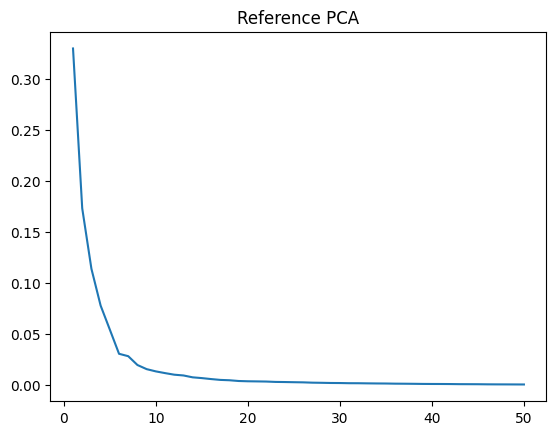

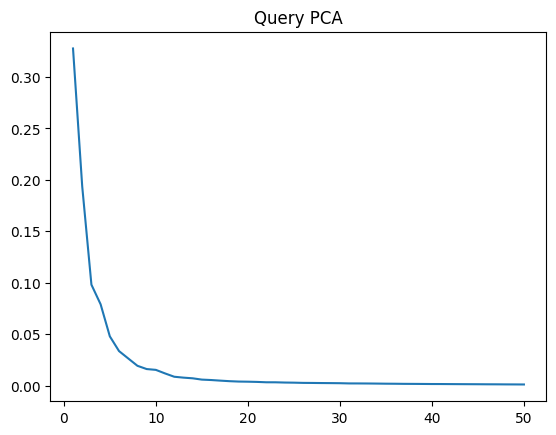

	Finding neighbors...


/Users/fero3l/opt/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


	Finding Louvain communities...

Step 2: Find closest matching communities

Step 3: Find closest matching reference cells in communities
	Matching query 0 to reference ['19', '16']...
	Matching query 1 to reference ['7', '9']...
	Matching query 2 to reference ['5', '2', '23']...
	Matching query 3 to reference ['5']...
	Matching query 4 to reference ['27', '3']...
	Matching query 5 to reference ['5', '27', '29']...
	Matching query 6 to reference ['4', '24', '26']...
	Matching query 7 to reference ['10', '20', '38']...
	Matching query 8 to reference ['7']...
	Matching query 9 to reference ['12', '0', '8', '40']...
	Matching query 10 to reference ['21', '6', '34']...
	Matching query 11 to reference ['40', '17', '28']...
	Matching query 12 to reference ['21', '22']...
	Matching query 13 to reference ['4']...
	Matching query 14 to reference ['14', '1']...
	Matching query 15 to reference ['27']...
	Matching query 16 to reference ['13', '18']...
	Matching query 17 to reference ['37', '33', '3

In [19]:
var_series = pd.Series(\
    que_adata.var.index.values, 
    index=que_adata.var.index.values)

preds = cellharmony(\
    reference_adata=ref_adata, 
    query_adata=que_adata, 
    obs_field="cluster", 
    var_series=var_series,
    reference_npcs=30, 
    query_npcs=30,
    reference_louvain_resolution=1, 
    query_louvain_resolution=1,
    use_zscore=True)

In [21]:
que_adata.obs[["r7", "r7_rho"]] = preds.loc[
    que_adata.obs.index.values,
    ["top_match", "rho"]].values
que_adata.obs

,cell_number,umap_x,umap_y,r7,r7_rho
:0,0,-5.456687,3.035202,preNeu-3-ADT,0.836751
:1,1,9.265275,2.305155,pre-MultiLin-1,0.903928
:2,2,1.211908,8.354475,preNeu-1,0.793765
:3,3,17.530994,-1.989260,pre-B-Il2ra,0.874901
:4,4,8.903340,4.119288,ETP-CC-4,0.925663
...,...,...,...,...,...
:1935032,1935032,15.370693,12.309156,ERP4-Bcl2l15,0.556924
:1935033,1935033,-2.737241,6.906129,preNeu-1,0.410792
:1935034,1935034,7.060609,2.757156,MultiLin-1,0.464509
:1935035,1935035,4.341044,13.691677,Baso,0.74229


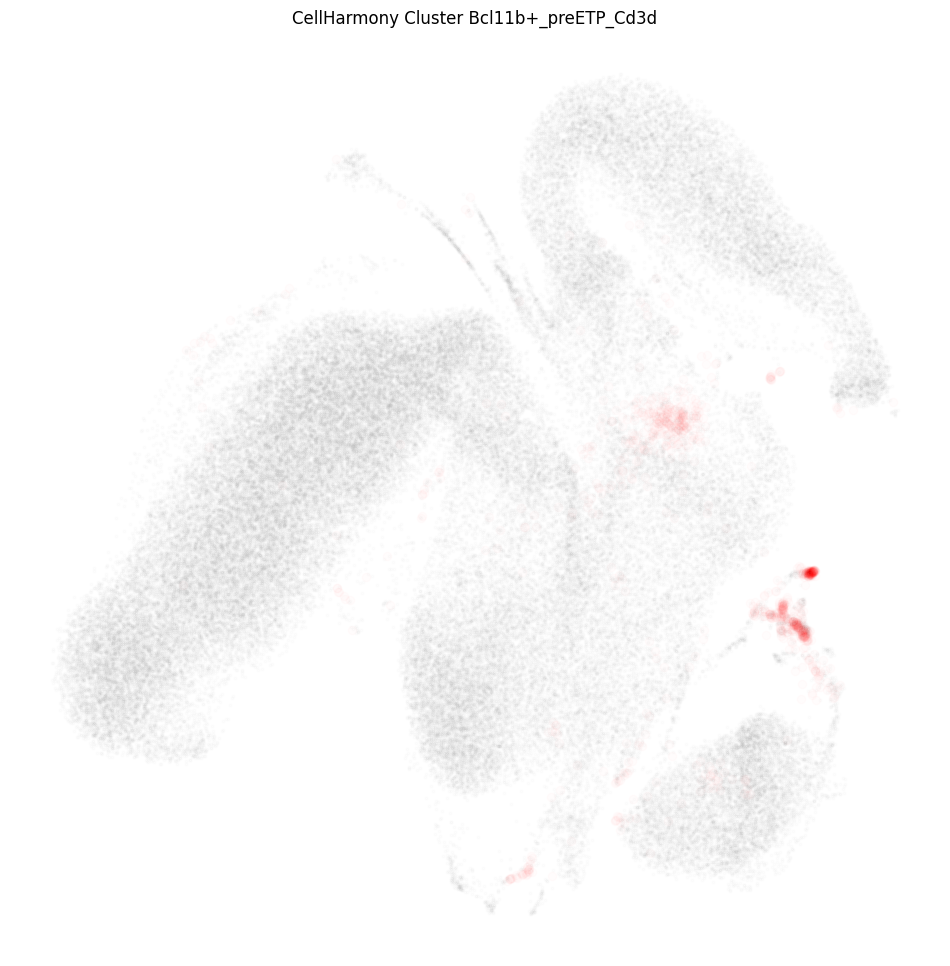

In [22]:
# Test plot pearson correlation for final model predictions
### Make test plots of cellharmony clusters over umap
# Plot R7 label predictions
sample_1e5 = pd.Series(\
    list(range(que_adata.obs.shape[0]))).sample(100000).sort_values().values
for tmp_cluster in que_adata.obs["r7"].unique():

    cluster_cells = que_adata.obs.loc[\
        que_adata.obs["r7"] == tmp_cluster].index.values

    plt.close("all")
    fig, ax = plt.subplots(figsize=(12,12))

    ax.scatter(\
        que_adata.obs.iloc[sample_1e5,:]['umap_x'], 
        que_adata.obs.iloc[sample_1e5,:]['umap_y'], 
        color="gray", 
        alpha=0.01,
        edgecolors=None, 
        s=4)
    ax.scatter(\
        que_adata.obs.loc[cluster_cells, 'umap_x'], 
        que_adata.obs.loc[cluster_cells, 'umap_y'],
        color="red",
        edgecolors=None, 
        alpha=0.01)


    # ax.set_xlim(umap_bounds.iloc[0,:].values)
    # ax.set_ylim(umap_bounds.iloc[1,:].values)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title("CellHarmony Cluster {}".format(tmp_cluster))
    plt.savefig("output/automated_py3_cellharmony_r7/"\
        "plot_r7_clusters_over_umap_redo/"\
        "{}_prediction.png".format(tmp_cluster))

Text(0.5, 1.0, 'CellHarmony Cluster BMCP')

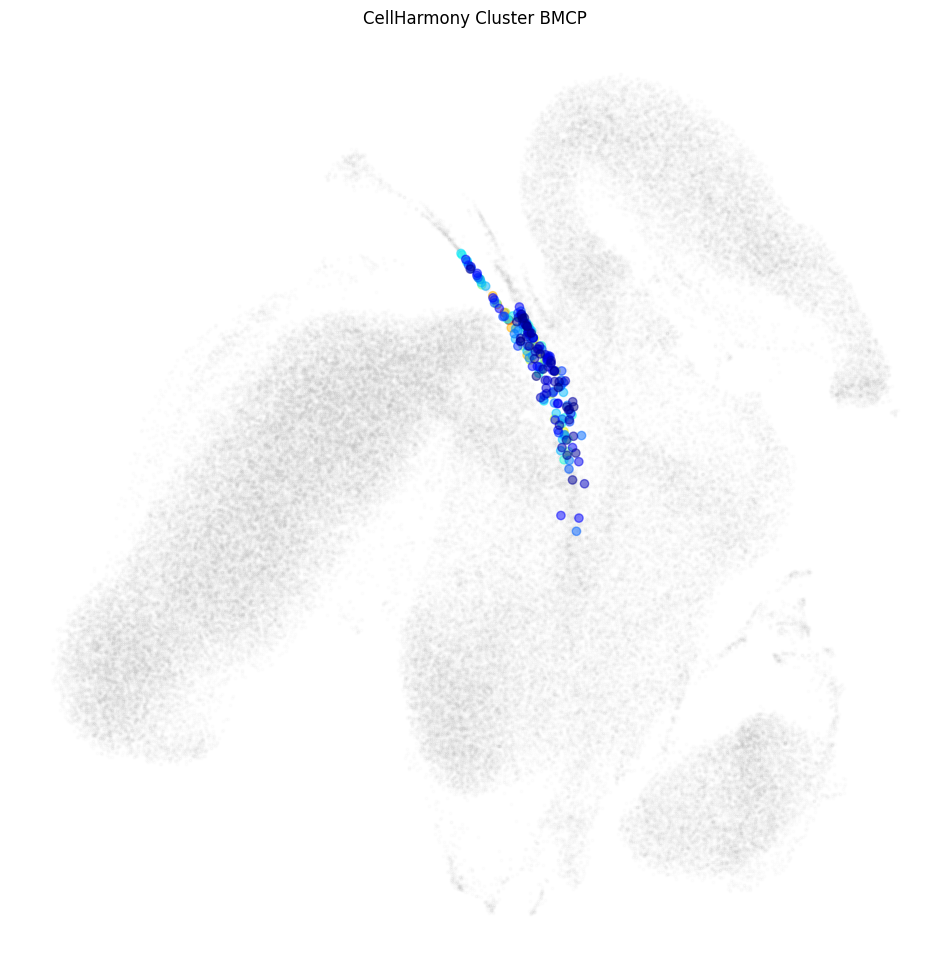

In [23]:
tmp_cluster = "BMCP"

seg_obs = que_adata.obs.loc[\
    que_adata.obs["r7"] == tmp_cluster].copy()

cluster_cells = seg_obs.sort_values(by="r7_rho", ascending=False).index.values[:200]

plt.close("all")
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(\
    que_adata.obs.iloc[sample_1e5,:]['umap_x'], 
    que_adata.obs.iloc[sample_1e5,:]['umap_y'], 
    color="gray", 
    alpha=0.01,
    edgecolors=None, 
    s=4)
ax.scatter(\
    que_adata.obs.loc[cluster_cells, 'umap_x'], 
    que_adata.obs.loc[cluster_cells, 'umap_y'],
    c=que_adata.obs.loc[cluster_cells, "r7_rho"],
    cmap="jet",
    # color="purple",
    edgecolors=None, 
    alpha=0.5)


# ax.set_xlim(umap_bounds.iloc[0,:].values)
# ax.set_ylim(umap_bounds.iloc[1,:].values)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.title("CellHarmony Cluster {}".format(tmp_cluster))


In [14]:
# # Sample evenly from r7 cluster definitions
# sorted_vcounts = que_adata.obs["r7"].value_counts().sort_values()

# target_final_n = int(1e5)
# n_groups = len(sorted_vcounts)
# tmp_remainder = target_final_n
# sampled_cells = []
# for tmp_cluster in sorted_vcounts.index.values:
#     target_sample_number = round(tmp_remainder / n_groups)
#     seg_cells = que_adata.obs.loc[que_adata.obs["r7"] == tmp_cluster].copy()
    
#     if seg_cells.shape[0] > target_sample_number:
#         sampled_cells.append(\
#             seg_cells.sample(target_sample_number).index.values)
#         tmp_remainder -= target_sample_number
#     else:
#         sampled_cells.append(seg_cells.index.values)
#         tmp_remainder -= seg_cells.shape[0]

#     n_groups -= 1


# sampled_cells = np.concatenate(sampled_cells)


In [24]:
que_adata.obs.to_csv("output/automated_py3_cellharmony_r7/"\
    "r7_py3_cellharmony_assigned_infinity_flow_groups_redo.csv",
    header=True, index=True, index_label="cell_id")



In [25]:
# Re-read data in to make final fcs after attaching cluster info and umap
tmp_fcs = read_fcs_into_anndata(\
    "output/infinity_flow/infinity_flow_reprediction_on_new_panal_logicle.fcs")

In [26]:
tmp_fcs = tmp_fcs[que_adata.obs.index.values,:]
tmp_cols = ["umap_x", "umap_y", "r7", "r7_rho"]
tmp_fcs.obs[tmp_cols] = que_adata.obs.loc[tmp_fcs.obs.index.values, tmp_cols].values

/var/folders/n6/grfs3y7x4ss_6xh6pydrsx7c0000gq/T/ipykernel_14272/309599003.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp_fcs.obs[tmp_cols] = que_adata.obs.loc[tmp_fcs.obs.index.values, tmp_cols].values


In [27]:
map_cluster_to_number = pd.Series(\
    list(range(1, 1 + len(sorted(que_adata.obs["r7"].unique())))), 
    index=sorted(que_adata.obs["r7"].unique()))

map_cluster_to_number

B-cell progenitor        1
BMCP                     2
Baso                     3
Bcl11b+_preETP_Cd3d      4
Bcl11b+_preETP_Tdrd5     5
                        ..
preNeu-3-Mac_C1qa       84
preNeu-Ebf1             85
proNeu-1                86
proNeu-1-ADT            87
proNeu-2                88
Length: 88, dtype: int64

In [28]:
tmp_fcs.obs["r7_number"] = [map_cluster_to_number[i] for i in \
    tmp_fcs.obs["r7"].values]

In [29]:
fcs_out_dir = "output/automated_py3_cellharmony_r7/fcs/"

# Create fcs file object
tmp_out = FCSFileObject(\
    fcs_file_path=os.path.join(\
        fcs_out_dir, 
        "infinity_flow_r7_labels_added_redo.fcs"), 
    mode='w')
tmp_df = anndata_to_df(tmp_fcs)
tmp_channel_names = tmp_fcs.var["name"].values

# UMAP already in provided flow file, only need to add r7 clusters
# Add new columns from obs dataframe
obs_features_to_add = ["r7_number", "r7_rho"]
tmp_df = pd.concat([tmp_df, tmp_fcs.obs[obs_features_to_add]], axis=1)
tmp_channel_names = np.concatenate([\
    tmp_channel_names, 
    [""] * len(obs_features_to_add)])

# Write out the fcs file object
tmp_out.load_data_from_pd_df(tmp_df, 
    input_channel_names=tmp_channel_names,
    additional_text_segment_values={"$CYT": 'Aurora'})
tmp_out.to_fcs(fcs_file_path=tmp_out.file_path)

# Write out the mapping of r7_number to r7 name
map_cluster_to_number.to_csv(os.path.join(\
    fcs_out_dir, "r7_to_number_cluster_mapping_redo.csv"), 
    header=False, 
    index=True)


Omitting spillover matrix...
WARNING! TEXT segment value for key $P26S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P27S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P28S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P29S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P30S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P31S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P32S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P33S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P34S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P35S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P36S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P38S is empty. Excluding from written file.